In [1]:
################# For running pre-training

from transformers import BertTokenizer, DataCollatorForLanguageModeling, BertForMaskedLM, TrainingArguments, Trainer, logging
import torch
# import tensorflow as tf
import pandas as pd
from datasets import Dataset
import multiprocessing
import numpy as np
import evaluate
import re

logging.set_verbosity_info()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up GPU backend
# https://pytorch.org/docs/main/notes/mps.html
# https://stackoverflow.com/questions/63423463/using-pytorch-cuda-on-macbook-pro
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
    # output expected:
    # tensor([1.], device='mps:0')

else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
# Read in events, clean and store as dataset
# https://towardsdatascience.com/does-bert-need-clean-data-part-2-classification-d29adf9f745a
def text_clean(x):

    ### Light
    x = x.lower() # lowercase everything
    x = x.encode('ascii', 'ignore').decode()  # remove unicode characters
    x = re.sub(r'https*\S+', ' ', x) # remove links
    x = re.sub(r'http*\S+', ' ', x)
    # cleaning up text
    x = re.sub(r'\'\w+', '', x) 
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    
    # ### Heavy
    # x = ' '.join([word for word in x.split(' ') if word not in stopwords])
    # x = re.sub(r'@\S', '', x)
    # x = re.sub(r'#\S+', ' ', x)
    # x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    # # remove single letters and numbers surrounded by space
    # x = re.sub(r'\s[a-z]\s|\s[0-9]\s', ' ', x)

    return x
df = pd.read_csv('eid_eventText.csv', usecols=['eid','event_text']).dropna(how='any',axis=0)
print(len(df))
df.drop_duplicates(subset=['event_text'],keep='first',inplace=True)
print(len(df))
df['event_text'] = df.event_text.apply(text_clean)
df = df[df['event_text'].str.split().str.len().gt(20)] # drops events with fewer than 20 words  
df.rename(columns={"event_text":"text"},inplace=True)
print(len(df))

dataset = Dataset.from_pandas(df).shuffle(seed=242)

395651
395595
375678


4524

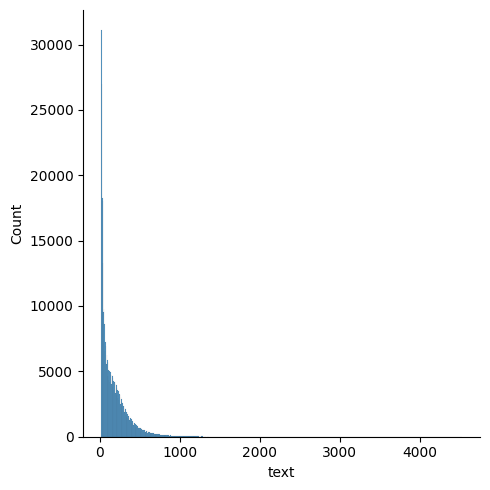

In [19]:
wc = df['text'].str.split().str.len()
sns.displot(wc)
max(wc)

Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors


5915


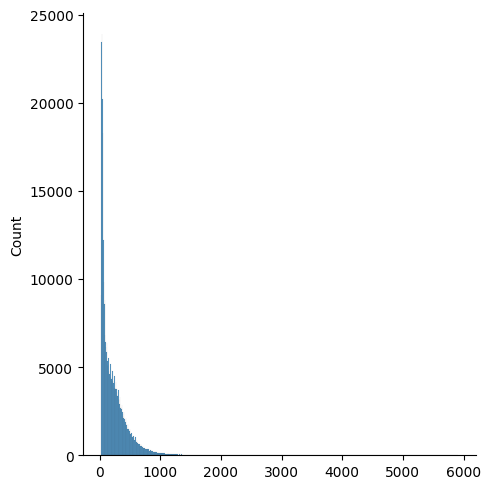

In [20]:
# Figuring out the max length of sequences to set limit for tokenizer
import seaborn as sns
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
token_lens = []
for txt in list(df.text):
    tokens = tokenizer.encode(txt, 
                            #   max_length=512, 
                            truncation=False)
    token_lens.append(len(tokens))
sns.displot(token_lens)
print(max(token_lens))

In [4]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(reports):
    return tokenizer(reports["text"], return_tensors="np", truncation=True, padding="max_length")

tokenized_ds = dataset.map(tokenize_function, batched=True, num_proc=multiprocessing.cpu_count())

loading file vocab.txt from cache at /Users/michaelrosen/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/michaelrosen/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /Users/michaelrosen/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json
loading configuration file config.json from cache at /Users/michaelrosen/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout

In [ ]:
# Model configuration
model = BertForMaskedLM.from_pretrained('bert-base-uncased')#,
                                        # torch_dtype=torch.float16, attn_implementation="sdpa", # these are for efficiency
                                        # num_labels=2 # https://github.com/huggingface/transformers/issues/27707
                                        # )
# model = BertForMaskedLM.from_pretrained('./event_trainer/checkpoint-43500') 

# Evaluation 
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.argmax(axis = -1)
    for i in range(0,len(labels)):
        metric.add_batch(predictions=preds[i], references=labels[i])
    # return metric.compute(predictions=preds, references=labels)
    return metric.compute()

# Data
train_eval_ds = tokenized_ds.train_test_split(test_size=0.1, shuffle=True,seed=42)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

# Trainer
training_args = TrainingArguments(
    output_dir="event_trainer4", 
    eval_strategy="epoch",
    eval_accumulation_steps = 32, # avoid OOM error, but putting preditictions during evalauation on the CPU
    per_device_eval_batch_size = 1, # This fixes the array size > 2**32 error if more than one batch is left on GPU
    num_train_epochs = 5,#, # default is 3,
    do_eval = True
    )

small_eval_dataset = train_eval_ds['test'].select(list(range(0,5000)))
# small_train_dataset = train_eval_ds["train"].select(list(range(0,1000)))
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_eval_ds["train"],
    # train_dataset=small_train_dataset,
    eval_dataset = small_eval_dataset,
    # eval_dataset = train_eval_ds["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

loading configuration file config.json from cache at /Users/michaelrosen/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.45.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /Users/michaelrosen/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetensors
Ber

In [ ]:
trainer.train(resume_from_checkpoint = True)
# trainer.train()

Loading model from event_trainer4/checkpoint-42000.
There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].
The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: eid, text, __index_level_0__. If eid, text, __index_level_0__ are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This li

In [1]:
x = pd.DataFrame(trainer.state.log_history)
x.head()

NameError: name 'pd' is not defined

In [13]:
trainer.state.best_model_checkpoint